In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Define season URLs
season_urls = {
    49: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=38",
    50: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=39",
    53: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=40",
    54: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=41",
    55: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=42",
    56: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=43",
    57: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=44",
    58: "https://strahovskaliga.cz/TymProfil/?TID=1882&YID=45",
    59: "https://strahovskaliga.cz/TymProfil/?TID=1882"  # current season
}

# Prepare to store match data
all_matches = []

# Function to get team players for a season
def get_team_players(soup):
    players = []
    players_table = next((table for table in soup.find_all("table", class_="table") if "Jméno" in [th.get_text() for th in table.find_all("th")]), None)
    if players_table:
        for row in players_table.find("tbody").find_all("tr"):
            cells = row.find_all("td")
            if len(cells) >= 2:
                players.append(cells[1].get_text(strip=True))
    return players

# Function to extract match details
def get_match_details(match_url, team_players, season):
    match_data = []
    match_response = requests.get(match_url)
    match_response.encoding = 'windows-1250'
    match_soup = BeautifulSoup(match_response.text, "html.parser")
    
    team_links = match_soup.find_all("a", href=re.compile(r"/TymProfil/\?TID=\d+"))
    if len(team_links) < 2:
        return match_data
    
    # Determine team and opponent IDs
    team1_id = re.search(r"TID=(\d+)", team_links[0]["href"]).group(1)
    team2_id = re.search(r"TID=(\d+)", team_links[1]["href"]).group(1)
    your_team_id, opponent_id = (team1_id, team2_id) if team1_id == "1882" else (team2_id, team1_id)

    date = match_soup.find("td").get_text(strip=True).split('-')[0].strip()
    goals = match_soup.find("h2", style="font-size: 40px;").get_text(strip=True)

    for team_div in match_soup.find_all("div", class_="pole"):
        player_table = team_div.find("table", class_="table-hover")
        if player_table:
            for row in player_table.find("tbody").find_all("tr"):
                cells = row.find_all("td")
                if len(cells) >= 3:
                    player_name = cells[1].get_text(strip=True)
                    player_goals = cells[2].get_text(strip=True) if cells[2].get_text(strip=True) else np.nan
                    if player_name in team_players:
                        match_data.append({"Player Name": player_name, "Opponent ID": opponent_id, "Date": date, "Goals": player_goals, "Season": season})
    return match_data

# Loop through each season to gather data
for season, url in season_urls.items():
    response = requests.get(url)
    response.encoding = 'windows-1250'
    soup = BeautifulSoup(response.text, "html.parser")
    
    team_players = get_team_players(soup)
    match_rows = soup.find_all("tr", {"title": "Detail Zapasu"})
    
    for row in match_rows:
        match_id = row.get("id")
        if match_id:
            match_url = f"https://strahovskaliga.cz/DetailZapasu/?MID={match_id}"
            all_matches.extend(get_match_details(match_url, team_players, season))

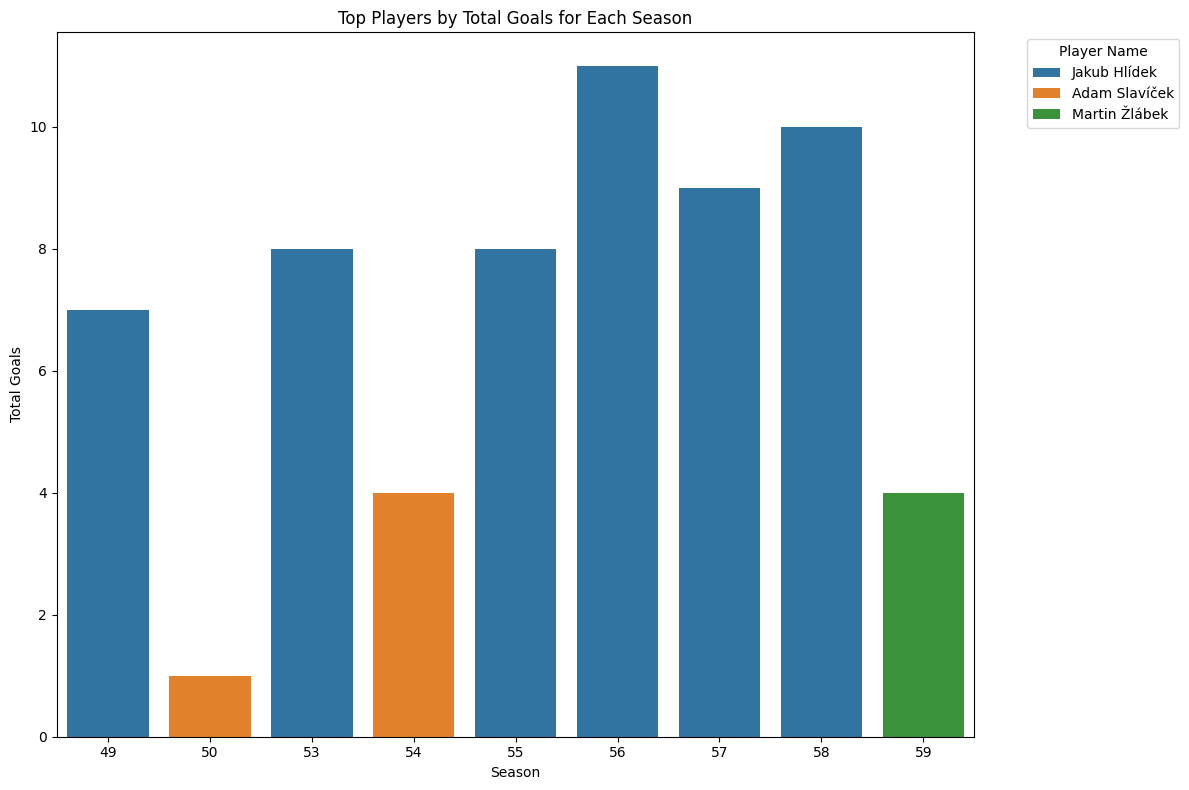

In [2]:
player_goals = pd.DataFrame(all_matches)

# Ensure 'Goals' column is numeric, coercing any errors to NaN
player_goals['Goals'] = pd.to_numeric(player_goals['Goals'], errors='coerce')

# Drop rows with NaN in 'Goals' to avoid issues with aggregation
player_goals = player_goals.dropna(subset=['Goals'])

# Calculate total goals per player per season
season_player_totals = player_goals.groupby(['Season', 'Player Name'])['Goals'].sum().reset_index()

# Identify top player for each season
top_players_per_season = season_player_totals.loc[season_player_totals.groupby('Season')['Goals'].idxmax()]

# Plotting the top players per season
plt.figure(figsize=(12, 8))
sns.barplot(data=top_players_per_season, x='Season', y='Goals', hue='Player Name', dodge=False)
plt.title("Top Players by Total Goals for Each Season")
plt.xlabel("Season")
plt.ylabel("Total Goals")
plt.legend(title='Player Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

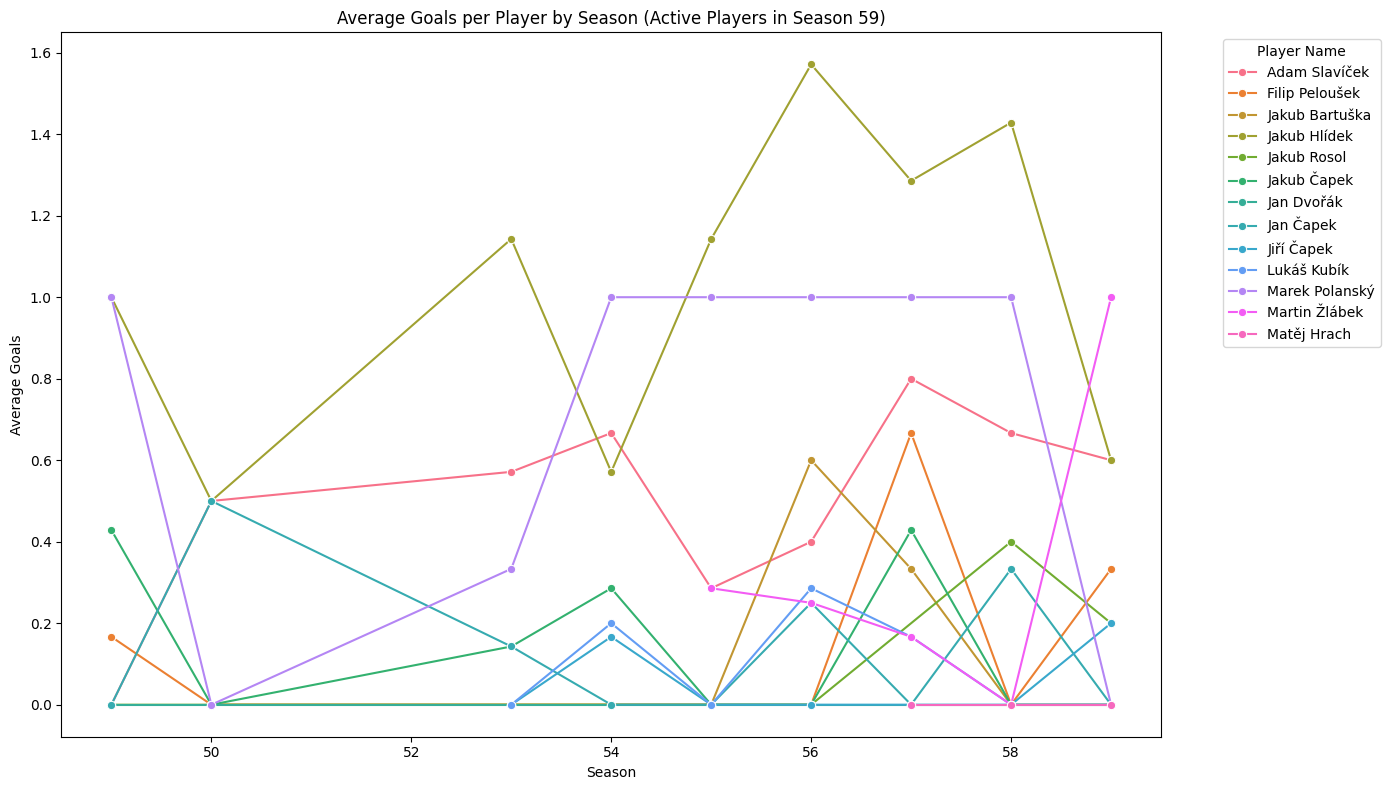

In [3]:
# Calculate average goals per player per season for active players in Season 59
current_season_players = player_goals[player_goals['Season'] == 59]['Player Name'].unique()
filtered_data = player_goals[player_goals['Player Name'].isin(current_season_players)].copy()
filtered_data['Goals'] = pd.to_numeric(filtered_data['Goals'], errors='coerce')
average_goals_per_season = filtered_data.groupby(['Player Name', 'Season'])['Goals'].mean().reset_index()

# Plotting the improvement trend for active players in Season 59
plt.figure(figsize=(14, 8))
sns.lineplot(data=average_goals_per_season, x='Season', y='Goals', hue='Player Name', marker='o')
plt.title("Average Goals per Player by Season (Active Players in Season 59)")
plt.xlabel("Season")
plt.ylabel("Average Goals")
plt.legend(title='Player Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


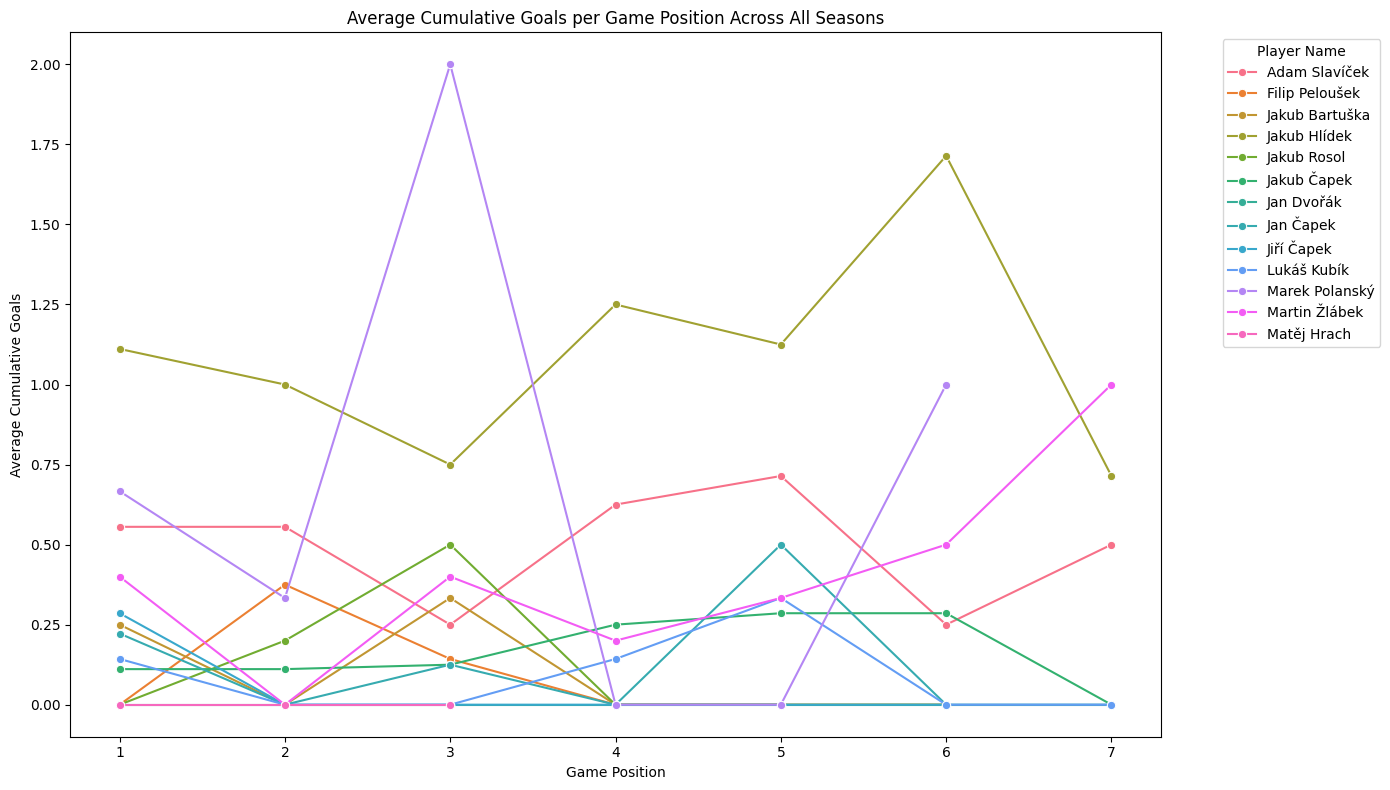

In [4]:
# Calculate cumulative average goals up to each game position for active players in Season 59
filtered_data['Goals'] = pd.to_numeric(filtered_data['Goals'], errors='coerce')
filtered_data = filtered_data.dropna(subset=['Goals'])
filtered_data['Game Position'] = filtered_data.groupby(['Player Name', 'Season']).cumcount() + 1
cumulative_avg = filtered_data.groupby(['Player Name', 'Game Position'])['Goals'].mean().reset_index()

# Plotting the cumulative average per game position
plt.figure(figsize=(14, 8))
sns.lineplot(data=cumulative_avg, x='Game Position', y='Goals', hue='Player Name', marker='o')
plt.title("Average Cumulative Goals per Game Position Across All Seasons")
plt.xlabel("Game Position")
plt.ylabel("Average Cumulative Goals")
plt.legend(title='Player Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


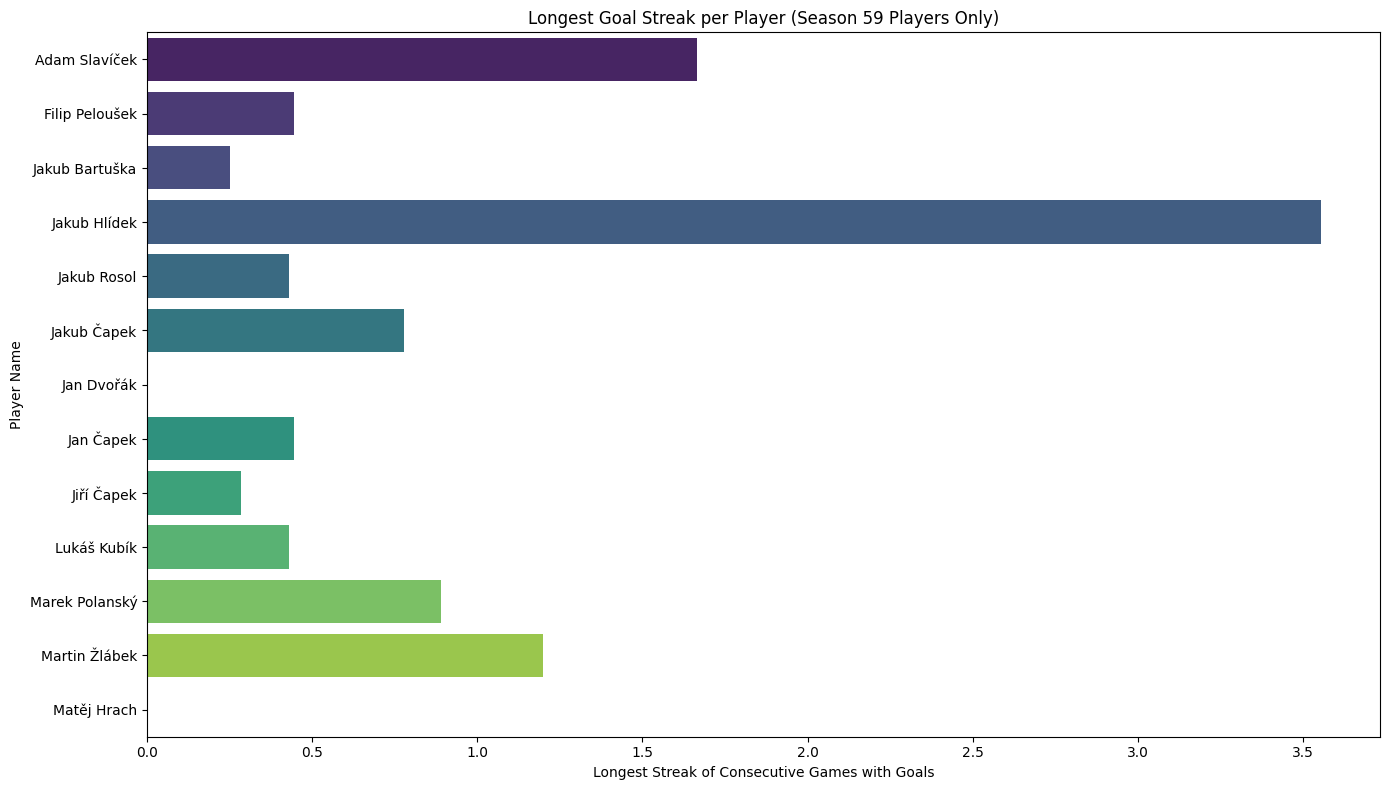

In [13]:

#TO JE STPANEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE



# Ensure 'Date' column is in datetime format
player_goals['Date'] = pd.to_datetime(player_goals['Date'], format="%d.%m.%Y", errors='coerce')

# Ensure 'Goals' column is numeric and convert to integers, dropping any NaN values
player_goals['Goals'] = pd.to_numeric(player_goals['Goals'], errors='coerce').fillna(0).astype(int)

# Filter data to include only players in Season 59
season_59_players = player_goals[player_goals['Season'] == 59]['Player Name'].unique()
filtered_data = player_goals[player_goals['Player Name'].isin(season_59_players)].copy()

# Calculate longest streaks for players in Season 59
def calculate_goal_streaks(data):
    longest_streaks = []
    for player, group in data.groupby(['Player Name', 'Season']):
        # Sort each player's games by date to ensure streak calculation is in order
        group = group.sort_values(by='Date')
        
        max_streak = 0
        current_streak = 0
        for goal in group['Goals']:
            if goal > 0:  # If the player scored in this game
                current_streak += 1
                max_streak = max(max_streak, current_streak)
            else:
                current_streak = 0  # Reset streak if no goals scored in this game
        longest_streaks.append({'Player Name': player[0], 'Longest Streak': max_streak})  # Store as integer
    return pd.DataFrame(longest_streaks)

# Recalculate the longest streaks for Season 59 players
longest_streaks_df = calculate_goal_streaks(filtered_data)

# Plotting without error bars and ensuring streaks are integers
plt.figure(figsize=(14, 8))
sns.barplot(data=longest_streaks_df, x='Longest Streak', y='Player Name', hue='Player Name', palette='viridis', dodge=False, errorbar=None, legend=False)
plt.title("Longest Goal Streak per Player (Season 59 Players Only)")
plt.xlabel("Longest Streak of Consecutive Games with Goals")
plt.ylabel("Player Name")
plt.tight_layout()
plt.show()


In [10]:
player_goals

,Player Name,Opponent ID,Date,Goals,Season
0,Jakub Hlídek,1870,14. 11. 2019,2,49
1,Vít Pazderník,1870,14. 11. 2019,1,49
2,Jakub Rosol,1870,14. 11. 2019,0,49
3,Jan Čapek,1870,14. 11. 2019,0,49
4,Filip Peloušek,1870,14. 11. 2019,0,49
...,...,...,...,...,...
514,Jan Čapek,1716,3. 10. 2024,0,59
515,Jiří Čapek,1716,3. 10. 2024,0,59
516,Jakub Hlídek,1716,3. 10. 2024,0,59
517,Jakub Čapek,1716,3. 10. 2024,0,59
